# Fire resistance regression

## Auxiliar functions

In [1]:
def predictions_vs_actual(X_train, y_train, X_test, y_test, model):
    """
    Creates two side-by-side scatter plots comparing predictions vs actual values
    for training and test sets, with custom axis configurations, R² in titles, 
    and a diagonal reference line.

    Arguments:
        X_train (array-like): Features for training set.
        y_train (array-like): True values for the training set.
        X_test (array-like): Features for test set.
        y_test (array-like): True values for the test set.
        model: Trained model with a predict() method.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate R²
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Function to calculate axis limits with extra space
    def get_axis_limits(pred, actual, margin=0.05):
        min_val = min(np.min(pred), np.min(actual))
        max_val = max(np.max(pred), np.max(actual))
        range_val = max_val - min_val
        return min_val - margin * range_val, max_val + margin * range_val

    # Calculate individual axis limits
    train_limits = get_axis_limits(y_train_pred, y_train)
    test_limits = get_axis_limits(y_test_pred, y_test)

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)

    # Training set plot
    axes[0].scatter(y_train_pred, y_train, alpha=0.7, color='red', s=20)
    axes[0].plot([train_limits[0], train_limits[1]], [train_limits[0], train_limits[1]], 
                 linestyle='--', color='gray', alpha=0.6, lw=2)  # Add diagonal
    axes[0].set_title(f'Training Set (R² = {r2_train:.2f})', fontsize=16)
    axes[0].set_xlabel('Prediction', fontsize=16)
    axes[0].set_ylabel('Actual', fontsize=16)
    axes[0].set_xlim(train_limits)
    axes[0].set_ylim(train_limits)

    # Test set plot
    axes[1].scatter(y_test_pred, y_test, alpha=0.7, color='red', s=20)
    axes[1].plot([test_limits[0], test_limits[1]], [test_limits[0], test_limits[1]], 
                 linestyle='--', color='gray', alpha=0.6, lw=2)  # Add diagonal
    axes[1].set_title(f'Test Set (R² = {r2_test:.2f})', fontsize=16)
    axes[1].set_xlabel('Prediction', fontsize=16)
    axes[1].set_ylabel('Actual', fontsize=16)  # Ensure y-axis label appears
    axes[1].set_xlim(test_limits)
    axes[1].set_ylim(test_limits)

    # Re-enable top and right spines
    for ax in axes:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

    # Set the font size for tick labels
    axes[0].tick_params(axis='both', labelsize=16)
    axes[1].tick_params(axis='both', labelsize=16)

    # Adjust layout
    plt.tight_layout()
    plt.show()

## Library loading, settings and dataset load

Hide warnings

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Main libraries load

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import time

Additional libraries

In [4]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [5]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
pd.options.mode.chained_assignment = None

Load Fire Resistance dataset after FS

In [6]:
path = '/Users/manolo/Documents/Docencia/Tesis Doctorales/Elena Albeira Guirado Lucinio/Resistencia fuego/Datasets/'

In [7]:
df = pd.read_excel(path+'FR_FS_augmented.xlsx')

In [8]:
df.head()

,Thickness,t180,Gypsum,Vermiculite,Fiberglass,Ash,Portland concrete,Silica sand,Zeolitized ash,Hidromag
0,2.0,35.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,15.7,30.0,9.5,0.5,0.0,0.0,0.0,0.0,0.0
2,1.5,26.0,99.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.5,15.7,30.0,9.5,0.5,0.0,0.0,0.0,0.0,0.0
4,4.0,110.7,30.0,9.5,0.5,0.0,0.0,0.0,0.0,0.0


## Feature and target split

In [9]:
cat_feat = []
bin_feat = []
target = 't180'
exclude = cat_feat + bin_feat + [target]
num_feat = [col for col in df.columns if col not in exclude]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(columns = target),
                                        df[target],
                                        test_size=0.25,
                                        random_state = 13
                                    )

print("Original dataframe size",df.shape)
print("Datafrane size without FS target for training", X_train.shape)
print("Target for training", y_train.shape)
print("Dataframe size without target for testing", X_test.shape)
print("Target for testing", y_test.shape)

Original dataframe size (134, 10)
Datafrane size without FS target for training (100, 9)
Target for training (100,)
Dataframe size without target for testing (34, 9)
Target for testing (34,)


Reset index

In [11]:
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

Transformer for numerical variable standardization and categorical variable one-hot encoding

In [12]:
data_transformer = ColumnTransformer(
  transformers = [
    ('rescale numeric', preprocessing.StandardScaler(), num_feat),
    ('recode categorical', 
      preprocessing.OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), 
      cat_feat)
    ])

### Pipeline set-up

In [13]:
dtr = Pipeline(steps = [("prep", data_transformer), ('dtr', DecisionTreeRegressor())])
rfr = Pipeline(steps = [("prep", data_transformer), ('rfr', RandomForestRegressor())])
gbr = Pipeline(steps = [("prep", data_transformer), ('gbr', GradientBoostingRegressor())])
lr = Pipeline(steps=[("prep", data_transformer), ("lr",LinearRegression())])
ridge = Pipeline(steps=[("prep", data_transformer), ("ridge",Ridge())])
lasso = Pipeline(steps=[("prep", data_transformer), ("lasso",Lasso())])
knr = Pipeline(steps=[("prep", data_transformer), ("knr",KNeighborsRegressor())])
mlp = Pipeline(steps=[("prep", data_transformer), ("mlp",MLPRegressor())])
xgr = Pipeline(steps=[("prep", data_transformer), ("xgr",XGBRegressor())])

### RandomSearch

In [14]:
# Decision tree
grid_rs_dtr = {"dtr__max_depth": list(np.arange(1, 30, step = 1)) 
              }
# Random Forest
grid_rs_rfr = {"rfr__n_estimators": list(np.arange(1, 100, step = 1)), 
                     
                     "rfr__max_depth": list(np.arange(1, 50, step = 1)), 
                      
                     "rfr__max_features": [1, "sqrt", 3, 4, 5, 6, 7] 
                     }
# Gradient Boosting
grid_rs_gbr = {"gbr__loss": ["squared_error"],
                          "gbr__learning_rate": list(np.arange(0.01, 1, step = 0.005)), 
                          
                          "gbr__n_estimators": list(np.arange(1, 30, step = 1)), 
                          
                          "gbr__max_depth": list(np.arange(5, 30, step = 1)), 
                          
                          "gbr__subsample": list(np.arange(0.1, 1, step = 0.1)), 
                          
                          "gbr__max_features": ["sqrt", 2, 4, 8], 
                          }
# Ridge
grid_rs_ridge= {'ridge__alpha': list(np.arange(0.1, 20, step = 0.1))}

# Lasso
grid_rs_lasso= {'lasso__alpha': list(np.arange(0.1, 20, step = 0.1))}

# KNeighbors
grid_rs_knr = {"knr__n_neighbors": list(np.arange(1, 15, step = 1)), 
                  "knr__weights": ["uniform","distance"]  
                  }

# Multi layer perceptron
grid_rs_mlp = {"mlp__hidden_layer_sizes": [(4,),             
                                        (4,4),
                                           (8,),             
                                        (8,8),
                                        (16,),          
                                        (16,16)],
                                           
           "mlp__activation": ["relu"], 
            
           "mlp__solver": ["adam"], 
            
           "mlp__alpha": [0.0, 0.05, 0.1], 
            
           "mlp__validation_fraction": [0.05, 0.1, 0.15], 
           "mlp__early_stopping": [True],    
           "mlp__max_iter": [10000],
            
           "mlp__learning_rate_init": list(np.arange(0.001, 0.5, step = 0.05)) 
           }

# XGBRegressor

grid_rs_xgr = {'xgr__max_depth': list(np.arange(1, 20, step = 1)),
            'xgr__learning_rate': list(np.arange(0.001, 0.5, step = 0.05)),
            'xgr__n_estimators': list(np.arange(10, 200, step = 10))
            }

In [15]:
rs_dtr = RandomizedSearchCV(dtr, 
                    grid_rs_dtr,
                    n_iter = 100, 
                    cv=10, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)
rs_rfr = RandomizedSearchCV(rfr, 
                    grid_rs_rfr,
                    n_iter = 100, 
                    cv=10, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_gbr = RandomizedSearchCV(gbr, 
                    grid_rs_gbr,
                    n_iter = 100, 
                    cv=10, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_ridge = RandomizedSearchCV(ridge, 
                    grid_rs_ridge,
                    n_iter = 100, 
                    cv=10, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_lasso = RandomizedSearchCV(lasso, 
                    grid_rs_lasso,
                    n_iter = 100, 
                    cv=10, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_knr = RandomizedSearchCV(knr, 
                    grid_rs_knr,
                    n_iter = 100, 
                    cv=10, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

rs_mlp = RandomizedSearchCV(mlp,
                      grid_rs_mlp,
                      n_iter = 100,
                      cv=10,
                      scoring='neg_mean_absolute_error',
                      verbose=1,
                      n_jobs=-1)

rs_xgr = RandomizedSearchCV(xgr, 
                    grid_rs_xgr,
                    n_iter = 100, 
                    cv=10, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)
rs_lr = GridSearchCV(lr,
                    param_grid={},
                    cv=10, 
                    scoring="neg_mean_absolute_error", 
                    verbose=1, 
                    n_jobs=-1)

In [16]:
all_rs_searchs = {"rs_dtr":rs_dtr,
                    "rs_rfr":rs_rfr,
                    "rs_gbr":rs_gbr,
                    "rs_ridge":rs_ridge,
                    "rs_lasso":rs_lasso,
                    "rs_knr":rs_knr,
                    "rs_mlp":rs_mlp,
                    "rs_xgr": rs_xgr,
                    "rs_lr": rs_lr
                    }

#### Model training

In [17]:
for name, grid_search in all_rs_searchs.items():
    start = time.time()
    print("Random Search of %s..." % name)
    grid_search.fit(X_train, y_train)
    stop = time.time()
    print(f"Training time: {stop - start} s")

Random Search of rs_dtr...
Fitting 10 folds for each of 29 candidates, totalling 290 fits
Training time: 0.9570872783660889 s
Random Search of rs_rfr...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Training time: 1.6159930229187012 s
Random Search of rs_gbr...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Training time: 0.3988468647003174 s
Random Search of rs_ridge...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Training time: 0.2184128761291504 s
Random Search of rs_lasso...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Training time: 0.21832966804504395 s
Random Search of rs_knr...
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Training time: 0.09667730331420898 s
Random Search of rs_mlp...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Training time: 4.569033145904541 s
Random Search of rs_xgr...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Training ti

#### Model performance

In [18]:
best_score_rs = [(nombre_modelo, grid_search.best_score_)
                                  for nombre_modelo, grid_search           
                                  in all_rs_searchs.items()]

best_score_rs_df = pd.DataFrame(best_score_rs, 
                                columns=["RandomSearchCV", 
                                         "Best score"]).sort_values(by="Best score", 
                                                                    ascending=False)

best_score_rs_df

,RandomSearchCV,Best score
2,rs_gbr,-3.806917
4,rs_lasso,-3.911607
3,rs_ridge,-3.918085
8,rs_lr,-3.933810
5,rs_knr,-4.062929
0,rs_dtr,-4.148056
1,rs_rfr,-4.155612
7,rs_xgr,-4.296214
6,rs_mlp,-4.414740


##### DTR

In [19]:
best_randomsearch = all_rs_searchs["rs_dtr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
print(best_randomsearch.best_params_)

{'dtr__max_depth': 12}


In [20]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 50.06914949218145
MAE: 4.6611303440488285
RMSE: 7.075955729947824


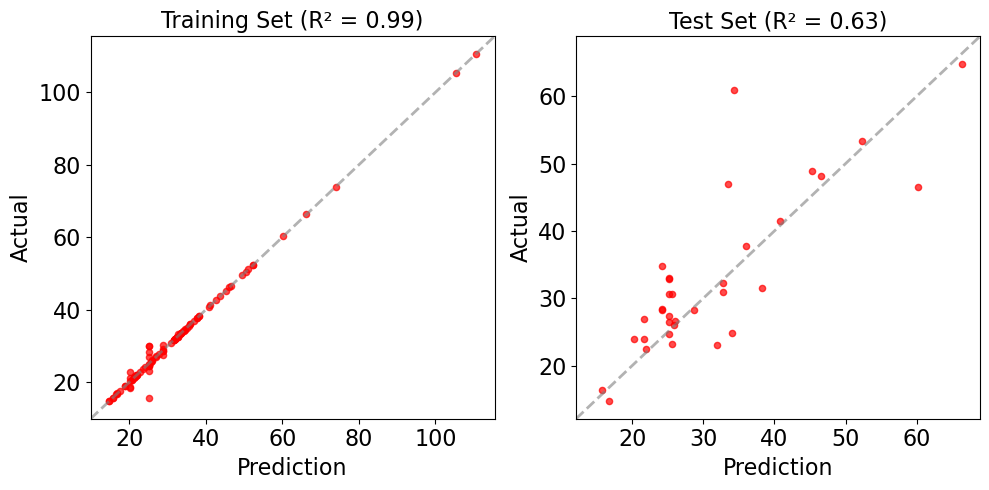

In [21]:
predictions_vs_actual(X_train, y_train, X_test, y_test, rs_dtr)

##### Ridge

In [22]:
best_randomsearch = all_rs_searchs["rs_ridge"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
print(best_randomsearch.best_params_)

{'ridge__alpha': 0.2}


In [23]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 18.037053710823503
MAE: 3.168315169171653
RMSE: 4.247005263809253


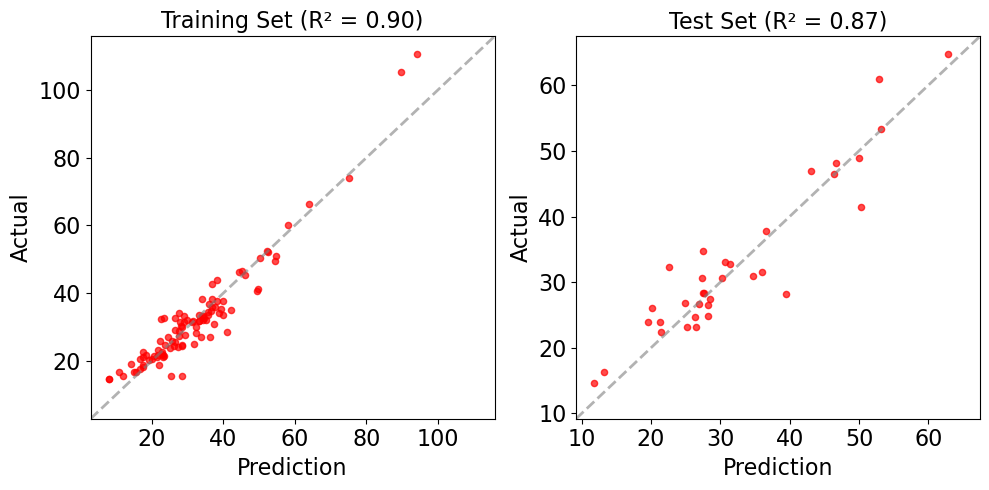

In [24]:
predictions_vs_actual(X_train, y_train, X_test, y_test, rs_ridge)

##### RFR

In [25]:
best_randomsearch = all_rs_searchs["rs_rfr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
print(best_randomsearch.best_params_)

{'rfr__n_estimators': 68, 'rfr__max_features': 7, 'rfr__max_depth': 45}


In [26]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 48.526665084502575
MAE: 4.5579965176516435
RMSE: 6.966108317023399


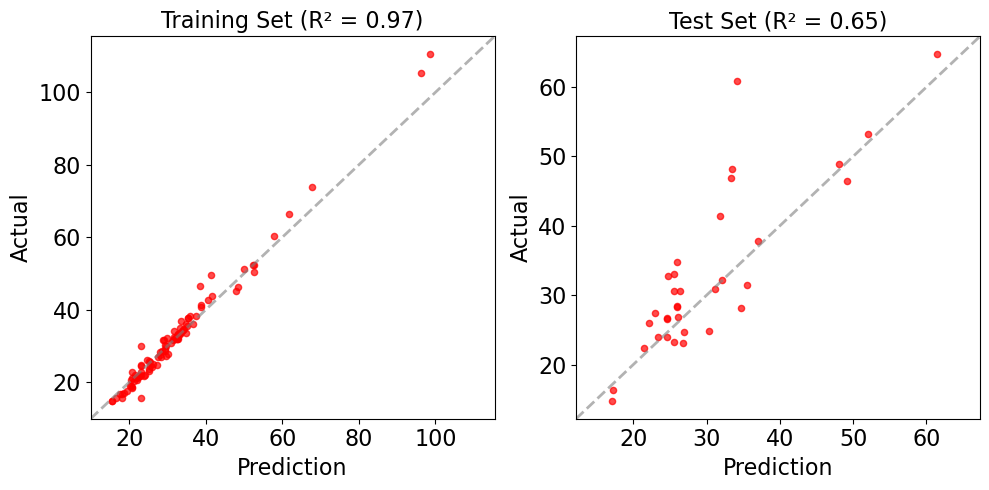

In [27]:
predictions_vs_actual(X_train, y_train, X_test, y_test, rs_rfr)

##### GBR

In [28]:
best_randomsearch = all_rs_searchs["rs_gbr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
print(best_randomsearch.best_params_)

{'gbr__subsample': 0.8, 'gbr__n_estimators': 17, 'gbr__max_features': 'sqrt', 'gbr__max_depth': 9, 'gbr__loss': 'squared_error', 'gbr__learning_rate': 0.25499999999999995}


In [29]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 45.38579232984123
MAE: 4.2612020130249055
RMSE: 6.736897826881541


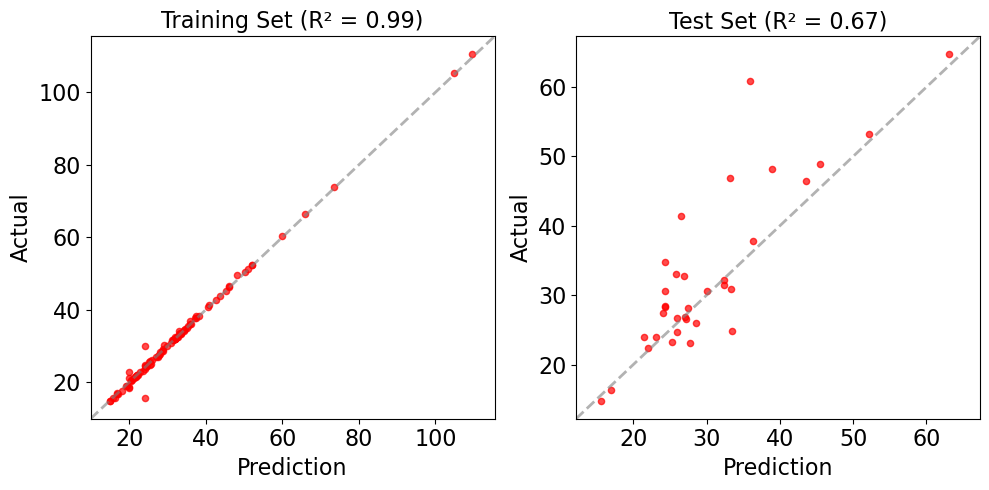

In [30]:
predictions_vs_actual(X_train, y_train, X_test, y_test, rs_gbr)

##### Lasso

In [31]:
best_randomsearch = all_rs_searchs["rs_lasso"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
print(best_randomsearch.best_params_)

{'lasso__alpha': 0.1}


In [32]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 18.395582603810272
MAE: 3.276180736215385
RMSE: 4.289007181599288


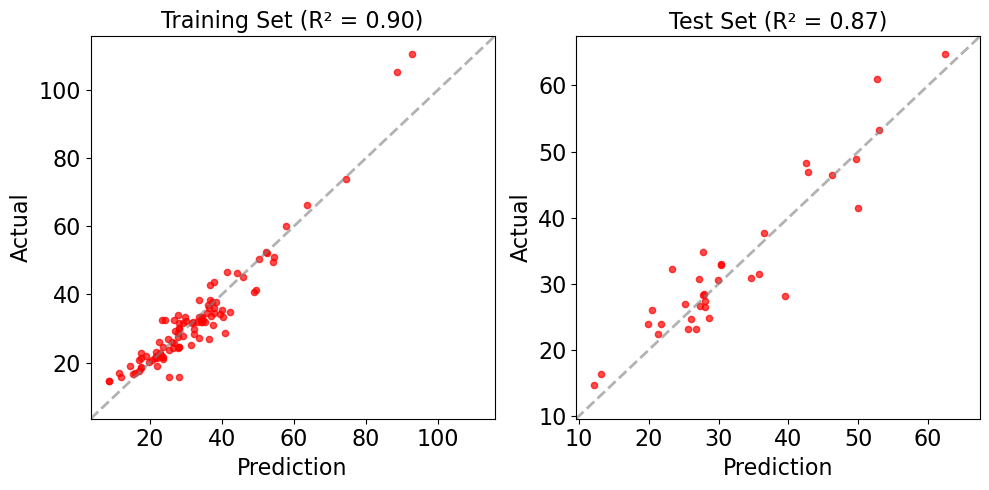

In [33]:
predictions_vs_actual(X_train, y_train, X_test, y_test, rs_lasso)

##### MLP

In [34]:
best_randomsearch = all_rs_searchs["rs_mlp"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
print(best_randomsearch.best_params_)

{'mlp__validation_fraction': 0.1, 'mlp__solver': 'adam', 'mlp__max_iter': 10000, 'mlp__learning_rate_init': 0.35100000000000003, 'mlp__hidden_layer_sizes': (16,), 'mlp__early_stopping': True, 'mlp__alpha': 0.05, 'mlp__activation': 'relu'}


In [35]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 53.677463987325716
MAE: 6.280476009351584
RMSE: 7.326490564200961


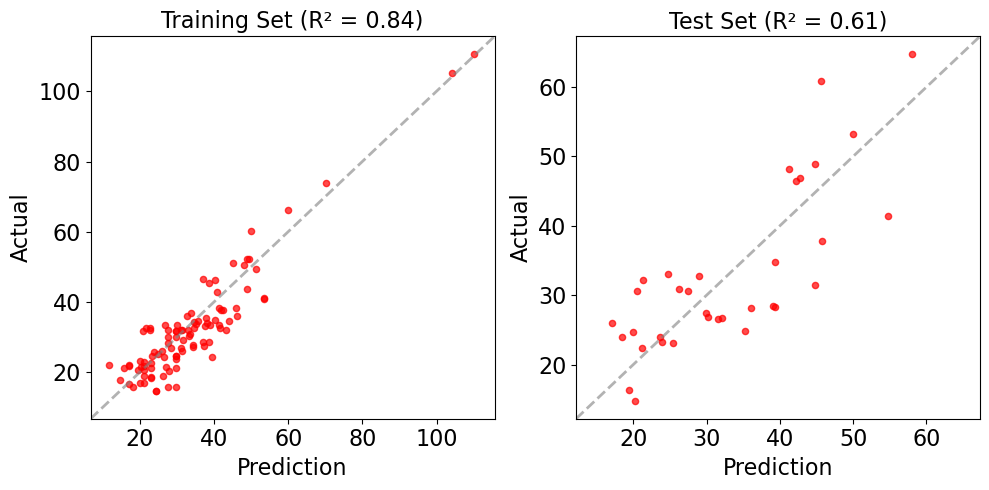

In [36]:
predictions_vs_actual(X_train, y_train, X_test, y_test, rs_mlp)

##### LR

In [37]:
best_randomsearch = all_rs_searchs["rs_lr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
print(best_randomsearch.best_params_)

{}


In [38]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 18.192514344081026
MAE: 3.1579088284622325
RMSE: 4.265268378904313


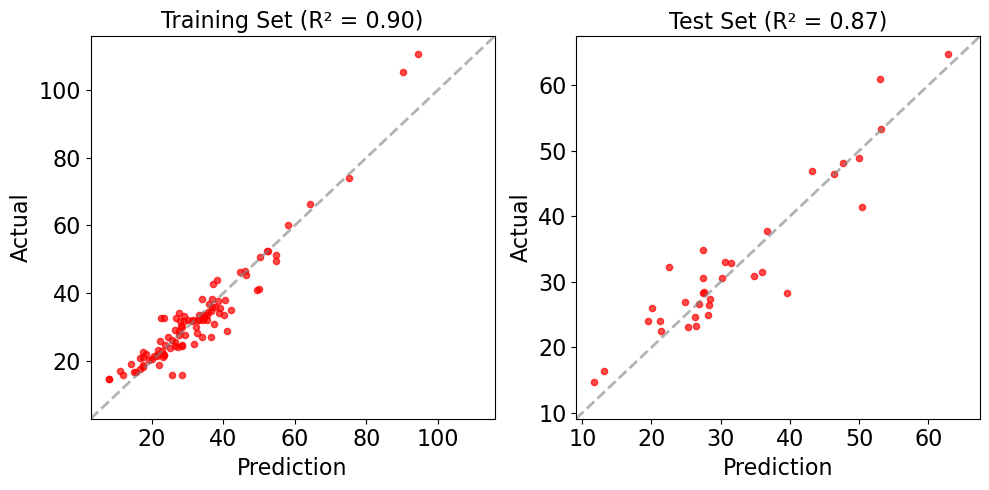

In [39]:
predictions_vs_actual(X_train, y_train, X_test, y_test, rs_lr)

##### XGR

In [40]:
best_randomsearch = all_rs_searchs["rs_xgr"]
# Save the model best model
best_pipeline = best_randomsearch.best_estimator_
print(best_randomsearch.best_params_)

{'xgr__n_estimators': 160, 'xgr__max_depth': 4, 'xgr__learning_rate': 0.051000000000000004}


In [41]:
mse = mean_squared_error(y_true=y_test, y_pred=best_pipeline.predict(X_test))
mae = mean_absolute_error(y_true=y_test,y_pred=best_pipeline.predict(X_test))
rmse = np.sqrt(mse)

print("MSE: " + str(mse))
print("MAE: " +  str(mae))
print("RMSE: " +  str(rmse))

MSE: 44.91625740487926
MAE: 4.212459067483892
RMSE: 6.701959221367977


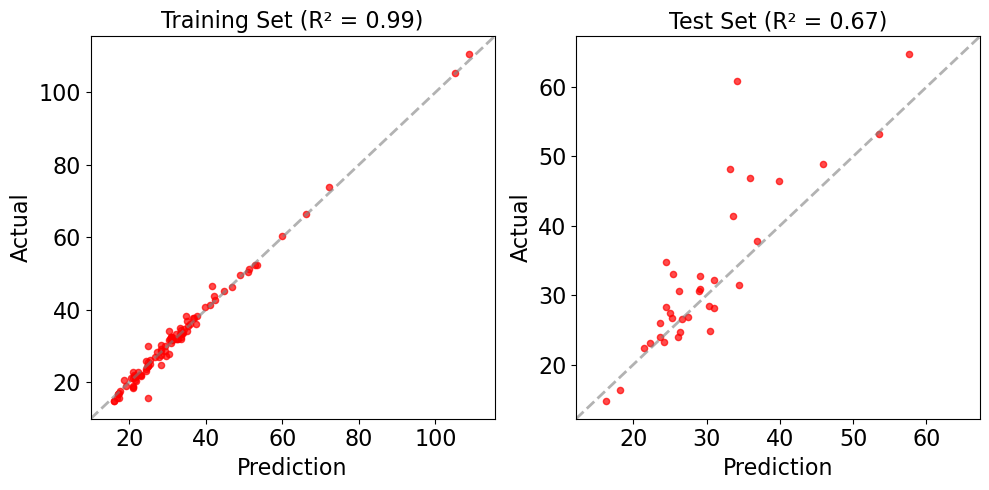

In [42]:
predictions_vs_actual(X_train, y_train, X_test, y_test, rs_xgr)